In [1]:
import utils
from batchgen import BatchGenerator
import models
import numpy as np
from os.path import join
from tensorflow import keras
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import random
from tqdm import tqdm
import pickle

In [2]:
input_shape = (256, 256, 3)

In [3]:
# load data
dt = utils.DirectoryTree("data/Category and Attribute Prediction Benchmark/")
with open(join(dt.Anno.path, 'meta.pickle'), 'rb' ) as f:
    data = pickle.load(f)

In [4]:
gen_test = BatchGenerator(image_paths = list(map(lambda path: join(dt.Img.path, path), data['img_names'])), 
                           bboxes = data['bbox_coords'],
                           categories=data['cat_labels'],
                           attributes=data['attr_labels'],
                           eval_status=data['eval_status'],
                           batch_size=5000,
                           image_size=input_shape[:2],
                           activation_map_size=(32, 32),
                           activation_map_mode='gaussian',
                           mode = 'test')

In [5]:
X, [Y_map, Y_cat, Y_attr] = gen_test.__getitem__(1)

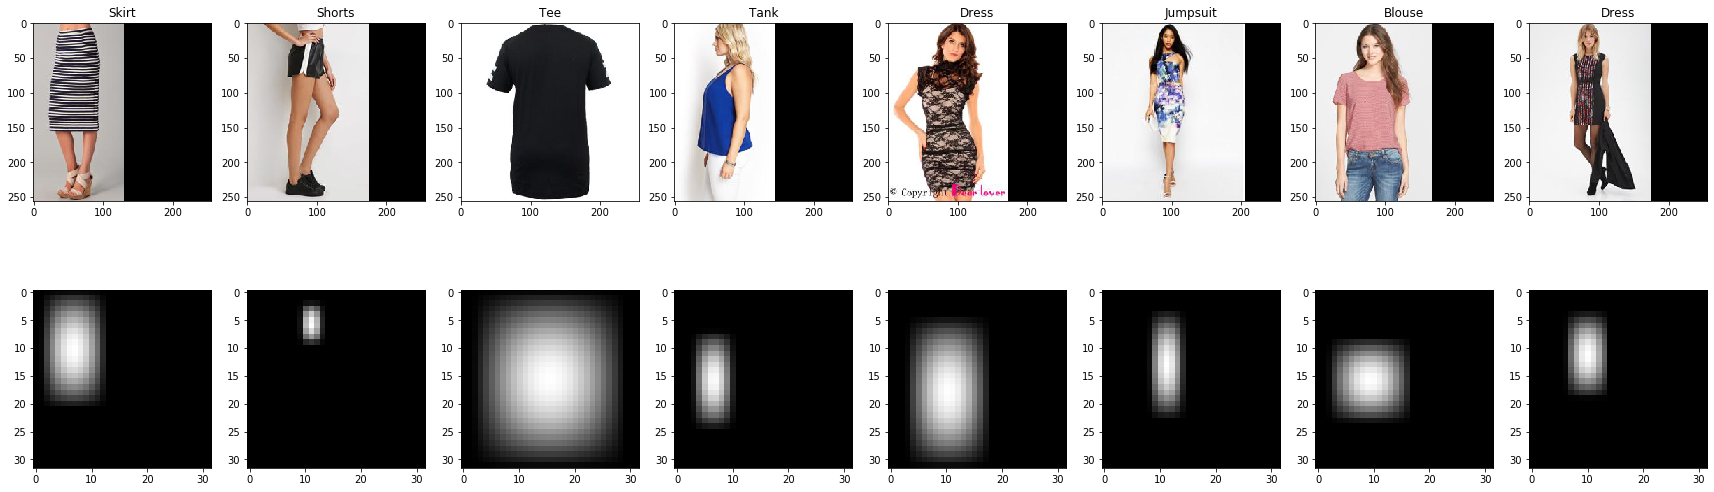

In [6]:
# plot example test images and activation maps
fig, axes = plt.subplots(2, 8, figsize = (30, 9))
for i, (img, act_map, cat) in enumerate(zip(X[:8], Y_map[:8], Y_cat[:8])):
    axes[0, i].imshow(img)
    act_map = np.expand_dims(act_map, axis = -1)
    axes[1, i].imshow(np.concatenate([act_map, act_map, act_map], axis = -1))
    axes[0, i].set_title("%s"%data['cat_index'][str(np.argmax(cat))])
plt.show()

In [8]:
model = keras.models.load_model("deploy/bigx_act.hdf5")

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [12]:
# Compute TSNE embeddings
tsne = TSNE()
pred_cat, pred_feat = model.predict(X.astype(np.float32), verbose = 0)

NameError: name 'pred_act' is not defined

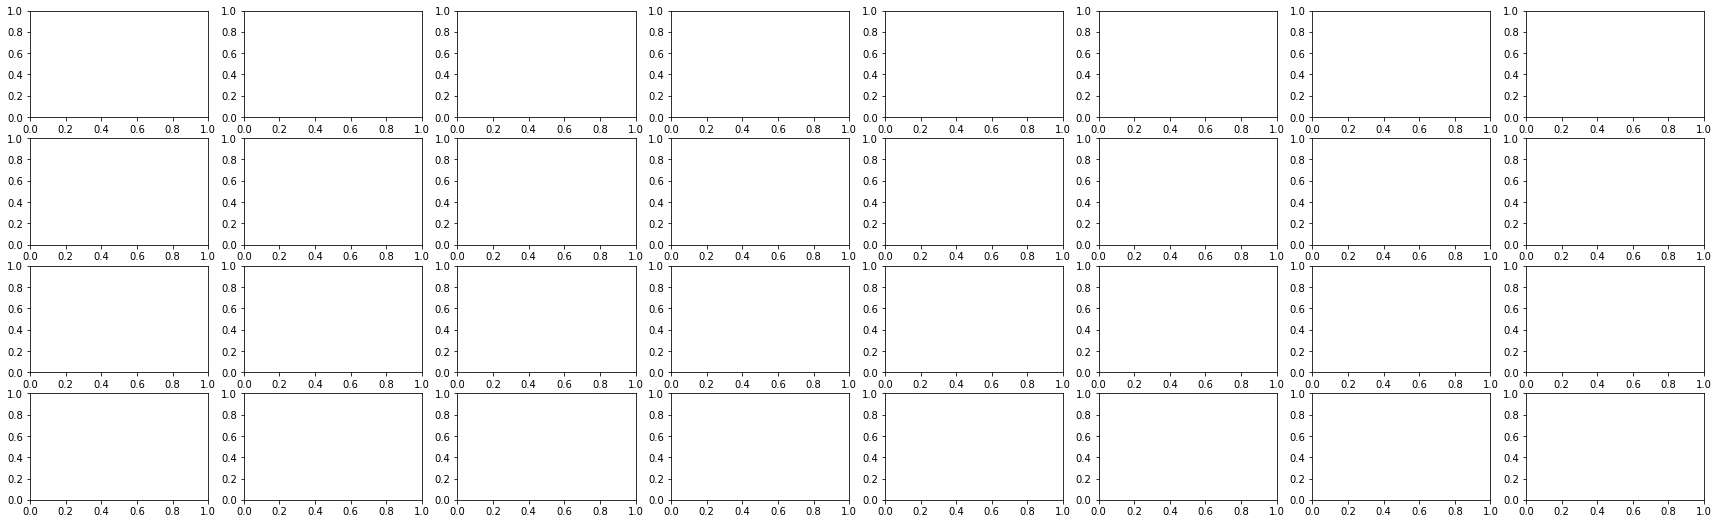

In [13]:
# plot example test images and activation maps
fig, axes = plt.subplots(4, 8, figsize = (30, 9))
for i, (img, act_map, cat, p_act_map, p_cat) in enumerate(zip(X[:8], Y_map[:8], Y_cat[:8], pred_act[:8], pred_cat[:8])):
    axes[0, i].imshow(img)
    axes[0, i].set_title("%s"%data['cat_index'][str(np.argmax(cat))])
    act_map = np.expand_dims(act_map, axis = -1)
    axes[1, i].imshow(np.concatenate([act_map, act_map, act_map], axis = -1))
    axes[2, i].imshow(img)
    axes[2, i].set_title("%s"%data['cat_index'][str(np.argmax(p_cat))])
    p_act_map = np.expand_dims(p_act_map, axis = -1)
    axes[3, i].imshow(np.concatenate([p_act_map, p_act_map, p_act_map], axis = -1))
    
plt.show()

In [ ]:
tsne_embeds = tsne.fit_transform(pred_cat)

In [ ]:
def visualize_scatter(data_2d, label_ids, label_index, figsize=(20,20), nb_classes = 10):
    plt.figure(figsize=figsize)
    plt.grid()
    
    classes, counts = np.unique(label_ids, return_counts = True)
    idx = np.argsort(counts)[::-1][:nb_classes]
    classes = classes[idx]
    counts = counts[idx]
    for i, label_id in enumerate(classes):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(i),
                    linewidth='1',
                    alpha=0.8,
                    label=label_index[str(label_id)])
    plt.legend(loc='best')

In [ ]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(100,100), image_zoom=1/2):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()
    plt.savefig("./tsne.png")

In [ ]:
visualize_scatter(tsne_embeds, np.argmax(Y_cat, axis = -1), data['cat_index'], nb_classes = 9)

In [ ]:
visualize_scatter_with_images(tsne_embeds, X)

In [14]:
rms_dist = lambda imgA, imgB: np.sqrt(np.mean((imgA - imgB)**2))
cos = lambda vA, vB : np.dot(vA, vB) / (np.sqrt(np.dot(vA,vA)) * np.sqrt(np.dot(vB,vB)))

def find_closest_neighbors(model, anchor_images, anchor_act_map, anchor_cat, anchor_attr, query_image, k = 16, dist_func = rms_dist):
    """
    :param model: keras model that has 3 outputs: act_map, cats, attrs
    :param anchor_images: images to query from
    :param anchor_features: 32x32 activation maps as feature matrices
    :param query_image: image to query -  will run model.predict to get its features 
    """
    # assert anchor_features.shape[1:] in (32, 32), str(anchor_features.shape)
    act_map, cat, attr = model.predict(query_image.reshape(-1,*input_shape).astype(np.float32))
    act_map = np.squeeze(act_map)
    cat = np.squeeze(cat)
    attr = np.squeeze(attr)
    # feat = cat 
    feat = np.concatenate([cat, attr])
    idx = np.where(np.argmax(anchor_cat, axis = -1) == np.argmax(cat)) # np.arange(0, len(anchor_images)) # 
    anchor_images = anchor_images[idx]
    anchor_act_map = anchor_act_map[idx]
    anchor_cat = anchor_cat[idx]
    anchor_attr = anchor_attr[idx]
    # anchor_features = anchor_cat
    anchor_features = np.concatenate([anchor_cat, anchor_attr], axis = -1)
    distances = np.array([dist_func(ff, feat) for ff in anchor_features]) # distance from categories
    # distances = np.array([dist_func(ff, act_map) for ff in anchor_act_map]) # distance from activations
    distances_idx = np.argsort(distances)[::-1]
    closest_images = anchor_images[distances_idx[:k]]
    closest_labels = anchor_cat[distances_idx[:k]]
    closest_act_maps = anchor_act_map[distances_idx[:k]]
    
    # plot query_image 
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(query_image)
    axes[0].set_title("Query image: %s"%data['cat_index'][str(np.argmax(cat))])
    q_act_map = np.clip(np.expand_dims(act_map, axis = -1), 0, 1)
    axes[1].imshow(np.concatenate([q_act_map, q_act_map, q_act_map], axis = -1))
    fig, axes = plt.subplots(2, k, figsize = (30, 6))
    fig.suptitle("Closest images")
    for i in range(k):
        axes[0, i].imshow(closest_images[i])
        axes[0, i].set_title("%s"%data['cat_index'][str(np.argmax(closest_labels[i]))])
        c_act_map = np.clip(np.expand_dims(closest_act_maps[i], axis = -1), 0, 1)
        axes[1, i].imshow(np.concatenate([c_act_map, c_act_map, c_act_map], axis = -1))
        
    plt.show()


In [15]:
test_idx = random.sample(list(range(len(X))), 1)[0]
test = X[test_idx]

In [16]:
# features = [cat, attr]
# dist_func = cos
closest_images = find_closest_neighbors(model, X, pred_act, pred_cat, pred_attr, test, k = 16, dist_func = cos)

NameError: name 'pred_act' is not defined

In [60]:
rms_dist = lambda imgA, imgB: np.sqrt(np.mean((imgA - imgB)**2))
cos = lambda vA, vB : np.dot(vA, vB) / (np.sqrt(np.dot(vA,vA)) * np.sqrt(np.dot(vB,vB)))

def find_closest_neighbors(model, anchor_images, anchor_cat, anchor_feat, query_image, k = 16, dist_func = cos):
    """
    :param model: keras model that has 3 outputs: act_map, cats, attrs
    :param anchor_images: images to query from
    :param anchor_features: 32x32 activation maps as feature matrices
    :param query_image: image to query -  will run model.predict to get its features 
    """
    cat, feat = model.predict(query_image.reshape(-1,*input_shape).astype(np.float32))
    cat = np.squeeze(cat)
    feat = np.squeeze(feat)
    idx = np.where(np.argmax(anchor_cat, axis = -1) == np.argmax(cat))
    anchor_images = anchor_images[idx]
    anchor_cat = anchor_cat[idx]
    anchor_feat = anchor_feat[idx]
    distances = np.array([dist_func(ff, feat) for ff in anchor_feat]) # distance from categories
    distances_idx = np.argsort(distances)[::-1]
    closest_images = anchor_images[distances_idx[:k]]
    closest_labels = anchor_cat[distances_idx[:k]]
    
    # plot query_image 
    fig = plt.Figure()
    plt.imshow(query_image)
    plt.title("Query image: %s"%data['cat_index'][str(np.argmax(cat))])
    fig, axes = plt.subplots(1, k, figsize = (30, 6))
    fig.suptitle("Closest images")
    for i in range(k):
        axes[i].imshow(closest_images[i])
        axes[i].set_title("%s"%data['cat_index'][str(np.argmax(closest_labels[i]))])        
    plt.show()

In [58]:
test_idx = random.sample(list(range(len(X))), 1)[0]
test = X[test_idx]

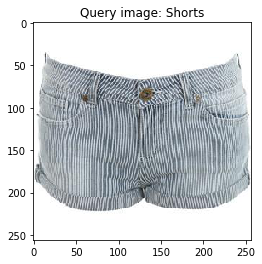

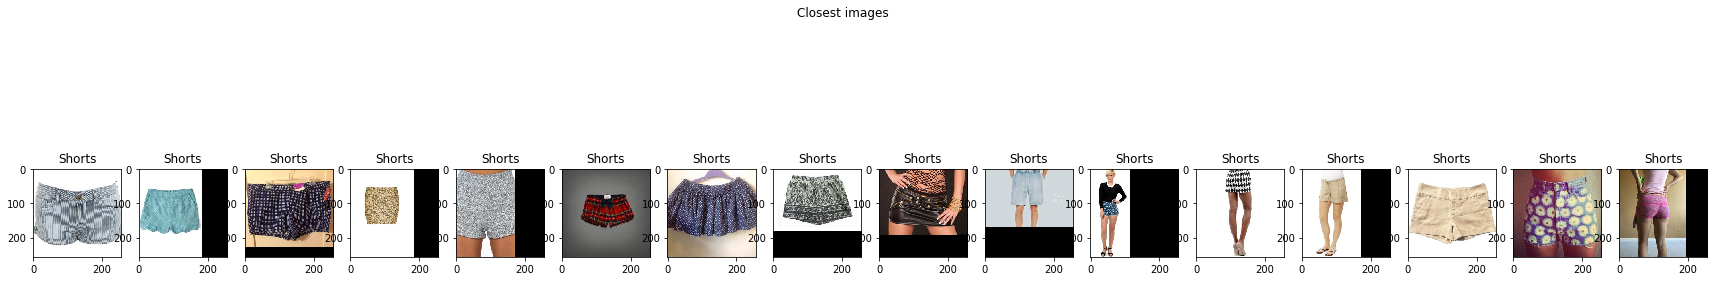

In [59]:
closest_images = find_closest_neighbors(model, X, pred_cat, pred_feat, test, k = 16, dist_func = cos)

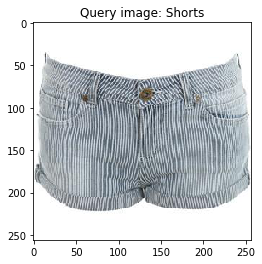

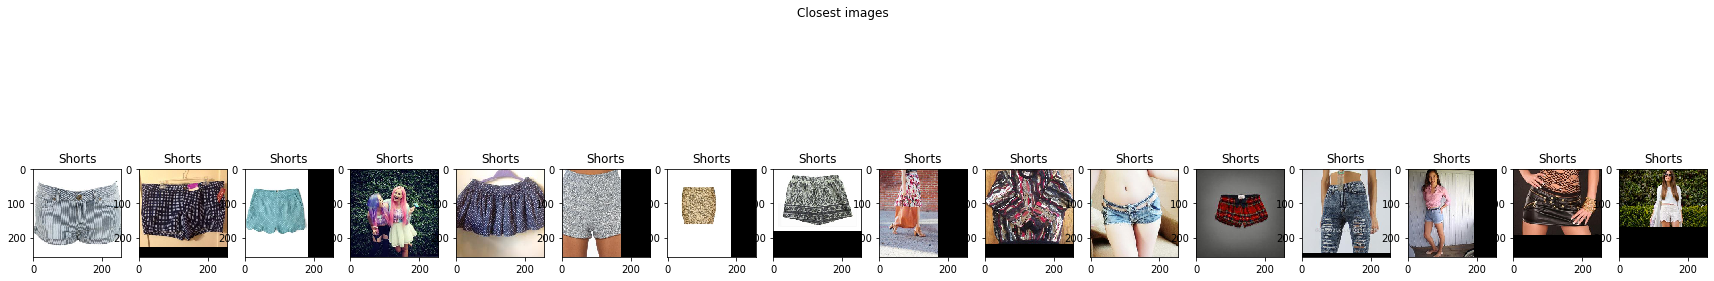

In [61]:
closest_images = find_closest_neighbors(model, X, pred_cat, pred_feat, test, k = 16, dist_func = cos)